In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from scipy import stats
from sanfis import SANFIS
from ANFISpy import ANFIS
import timeit
import seaborn as sns

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import pandas as pd

from skanfis import scikit_anfis
from skanfis.fs import *
from skanfis import *

Data

In [2]:
np.random.seed(42)
torch.manual_seed(42)

y_test = torch.load('y_test.pth').squeeze().numpy()

anfispy_preds = np.load('anfispy_preds.npy')
sanfis_preds = np.load('sanfis_preds.npy')
skanfis_preds = np.load('skanfis_preds.npy')

anfispy_time = np.load('anfispy_time.npy')
sanfis_time = np.load('sanfis_time.npy')
skanfis_time = np.load('skanfis_time.npy')

## Comparison

In [3]:
print(f'ANFISpy: {anfispy_time.mean():.2f} +- {anfispy_time.std():.2f} seconds')
print(f'SANFIS: {sanfis_time.mean():.2f} +- {sanfis_time.std():.2f} seconds')
print(f'SkANFIS: {skanfis_time.mean():.2f} +- {skanfis_time.std():.2f} seconds')

ANFISpy: 36.35 +- 0.04 seconds
SANFIS: 25.28 +- 0.09 seconds
SkANFIS: 103.43 +- 0.95 seconds


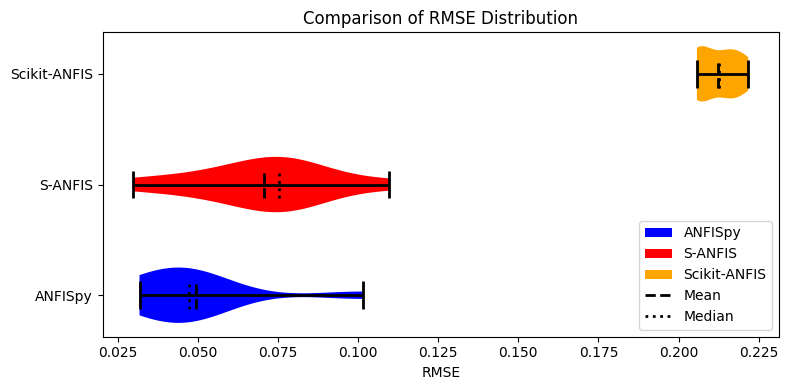

In [4]:
def compute_rmse(preds, y_true):
    rmses = []
    for run in range(preds.shape[0]):
        rmse = np.sqrt((((y_true - preds[run])**2).sum() / y_true.shape[0]))
        rmses.append(rmse)
    return np.array(rmses)

anfispy_rmse = compute_rmse(anfispy_preds, y_test)
sanfis_rmse = compute_rmse(sanfis_preds, y_test)
skanfis_rmse = compute_rmse(skanfis_preds, y_test)

data = [anfispy_rmse, sanfis_rmse, skanfis_rmse]
labels = ["ANFISpy", "S-ANFIS", "Scikit-ANFIS"]

plt.figure(figsize=(8, 4))

violin_parts = plt.violinplot(data, showmeans=True, showextrema=True, showmedians=True, orientation="horizontal")

colors = ['blue', 'red', 'orange']

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(1.)

for partname in ('cmeans',):
    vp = violin_parts[partname]
    vp.set_color('black')     
    vp.set_linestyle('--') 
    vp.set_linewidth(2)

for partname in ('cmedians',):
    vp = violin_parts[partname]
    vp.set_color('black')     
    vp.set_linestyle('dotted') 
    vp.set_linewidth(2)

for partname in ('cmins', 'cmaxes', 'cbars'):
    vp = violin_parts[partname]
    vp.set_color('black')
    vp.set_linewidth(2)

plt.yticks([1, 2, 3], labels)
plt.xlabel('RMSE')
plt.title('Comparison of RMSE Distribution')

legend_elements = [
    Patch(facecolor='blue', label='ANFISpy'),
    Patch(facecolor='red', label='S-ANFIS'),
    Patch(facecolor='orange', label='Scikit-ANFIS'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='Mean'),
    Line2D([0], [0], color='black', linestyle='dotted', linewidth=2, label='Median'),
]
plt.legend(handles=legend_elements, loc='lower right', frameon=True)

plt.tight_layout()
plt.show()

In [5]:
print(f'ANFISpy: {anfispy_rmse.mean():.4f} +- {anfispy_rmse.std():.4f}')
print(f'SANFIS: {sanfis_rmse.mean():.4f} +- {sanfis_rmse.std():.4f}')
print(f'SkANFIS: {skanfis_rmse.mean():.4f} +- {skanfis_rmse.std():.4f}')

ANFISpy: 0.0495 +- 0.0188
SANFIS: 0.0705 +- 0.0205
SkANFIS: 0.2125 +- 0.0059


# Statistical Test

In [6]:
print('Time')

stat, pvalue = stats.kruskal(*[anfispy_time, sanfis_time, skanfis_time])

print(f'p-value: {pvalue}')

pvalue_matrix = sp.posthoc_dunn([anfispy_time, sanfis_time, skanfis_time])

print(pvalue_matrix)

Time
p-value: 2.49000508218493e-06
          1             2             3
1  1.000000  1.108517e-02  1.108517e-02
2  0.011085  1.000000e+00  3.774248e-07
3  0.011085  3.774248e-07  1.000000e+00


In [7]:
stat, pvalue = stats.kruskal(*[anfispy_rmse, sanfis_rmse, skanfis_rmse])

print(f'p-value: {pvalue}')

pvalue_matrix = sp.posthoc_dunn([anfispy_rmse, sanfis_rmse, skanfis_rmse])

print(pvalue_matrix)

p-value: 2.1177301260247794e-05
          1         2         3
1  1.000000  0.140697  0.000005
2  0.140697  1.000000  0.002116
3  0.000005  0.002116  1.000000
